In [1]:
import os
import pickle
import yaml
import functools

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, feature

import ase
from ase.visualize.plot import plot_atoms

import ml_collections
from clu import checkpoint

from molnet import utils, train_state, train
from molnet.data import input_pipeline_online
from molnet.models import create_model
from configs import root_dirs
from analyses import make_predictions

from typing import Tuple

INDEX_TO_ELEM = {
    0: 'H',
    1: 'C',
    2: 'N',
    3: 'O',
    4: 'F',
}

2025-01-17 12:14:17.683635: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def load_from_workdir(
    workdir: str,
    return_attention: bool
):
    # Load the model config
    with open(os.path.join(workdir, "config.yaml"), "rt") as f:
        config = yaml.unsafe_load(f)
    config = ml_collections.ConfigDict(config)
    config.root_dir = root_dirs.get_root_dir("afms_rebias")
    config.model.return_attention_maps = return_attention

    print(config)

    # Create the model
    model = create_model(config.model)

    checkpoint_dir = os.path.join(workdir, "checkpoints")
    ckpt = checkpoint.Checkpoint(checkpoint_dir)

    apply_fn = model.apply
    tx = utils.create_optimizer(config)
    restored_state = ckpt.restore(state=None)['state']

    # Load the model state
    state = train_state.EvaluationState.create(
        apply_fn=apply_fn,
        params=restored_state['params'],
        batch_stats=restored_state['batch_stats'],
        tx=tx,
    )
    state = jax.tree_util.tree_map(jnp.asarray, state)

    return state, config


In [12]:
def plot_aggregate(x, y, save_name):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(x[0, ..., -1, 0], cmap='gray')
    axs[0].set_title(f"Input")

    axs[1].imshow(
        y[0].sum(axis=(-1, -2)),
        cmap='viridis',
        vmin=0,
    )

    plt.savefig(save_name)
    plt.close()


def plot_detail(x, y, save_name):
    # 2. Plot the full prediction [1, x, y, z, element]
    nrows = 10
    ncols = 9
    fig = plt.figure(figsize=(ncols * 2, nrows * 2))
    subfigs = fig.subfigures(2, 3, height_ratios=[8, 1], width_ratios=[1, 5, 1], wspace=0.02, hspace=0.02)

    # Plot the input in subfigs[0, 0]
    ax = subfigs[0, 0].subplots(10,1)
    for i in range(10):
        ax[i].imshow(x[0, ..., i, 0], cmap='gray')
        ax[i].axis('off')

    # Plot the output in subfigs[0, 1]
    ax = subfigs[0, 1].subplots(10, 7)
    for i in range(10):
        for j in range(7):
            ax[i, j].imshow(y[0, ..., i, j], cmap='viridis')
            ax[i, j].axis('off')

    # Plot the sum of the output in subfigs[0, 2]
    ax = subfigs[0, 2].subplots(10, 1)
    for i in range(10):
        ax[i].imshow(y[0, ..., i, :].sum(axis=-1), cmap='viridis')
        ax[i].axis('off')

    # Plot the sum of the output in subfigs[1, 1]
    ax = subfigs[1, 1].subplots(1, 7)
    for i in range(7):
        ax[i].imshow(y[0, ..., :, i].sum(axis=-1), cmap='viridis')
        ax[i].axis('off')

    # Plot the total sum in subfigs[1, 2]
    ax = subfigs[1, 2].subplots(1, 1)
    ax.imshow(y[0].sum(axis=(-1, -2)), cmap='viridis')
    ax.axis('off')

    plt.tight_layout()
    plt.savefig(save_name)
    plt.close()

In [4]:
@jax.jit
def predict(state, x):
    preds, attention = state.apply_fn(
        {'params': state.params, 'batch_stats': state.batch_stats},
        x,
        training=False,
    )
    return preds, attention

In [5]:
workdir = "/u/79/kurkil1/unix/work/molnet/runs/bf16-augs-halogen-adam-3e-4-z10-gx5/"

state, config = load_from_workdir(
    workdir=workdir,
    return_attention=True
)

batch_size: 24
cutout_probs:
- 0.5
- 0.3
- 0.1
- 0.05
- 0.05
dataset: afm_192_light_bromine
debug: false
eval_every_steps: 2000
gaussian_factor: 5.0
interpolate_input_z: null
learning_rate: 0.0003
learning_rate_schedule: constant
learning_rate_schedule_kwargs:
  decay_steps: 50000
  init_value: 0.0003
  peak_value: 0.0006
  warmup_steps: 2000
log_every_steps: 100
loss_fn: mse
max_atoms: 54
max_shift_per_slice: 0.02
model:
  attention_activation: sigmoid
  attention_channels:
  - 32
  - 32
  - 32
  - 32
  - 32
  conv_activation: relu
  decoder_channels:
  - 256
  - 128
  - 64
  - 32
  - 16
  decoder_kernel_size:
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  dtype: bfloat16
  encoder_channels:
  - 16
  - 32
  - 64
  - 128
  - 256
  encoder_kernel_size:
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  - - 3
    - 3
    - 3
  model_name: Attention-UNet
  output_activ

2025-01-17 12:14:41.188185: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [10]:
root_dir = '/l/exp_data/'
exclude_dirs = ["Nitrophenyls"]
datasets = [
    os.path.join(root_dir, folder) 
    for folder in os.listdir(root_dir)
    if os.path.isdir(os.path.join(root_dir, folder))
]

# Create datasets directory, where the key is the dataset name and the value is all the files in the dataset.
datasets = {
    dataset.split("/")[-1]: [os.path.join(dataset, file) for file in os.listdir(dataset) if "Xe" not in file]
    for dataset in datasets
    if dataset.split("/")[-1] not in exclude_dirs
}

In [13]:
outputdir = os.path.join(workdir, "exp_predictions")
os.makedirs(outputdir, exist_ok=True)
for ds, fnames in datasets.items():
    for f in fnames:
        d = np.load(f, allow_pickle=True)
        x, lx, ly = d['data'], d['lengthX'], d['lengthY']

        x = jnp.array(x)

        # If x.shape[-1] < 10, we need to pad it with zeros
        if x.shape[-1] < 10:
            x = jnp.pad(x, ((0, 0), (0, 0), (0, 10 - x.shape[-1])))

        # If x.shape[-1] > 10, we run the prediction for all slices of x
        xs = []
        if x.shape[-1] > 10:
            for i in range(x.shape[-1] - 10):
                xs.append(x[:, :, i:i+10])
        else:
            xs.append(x)

        for i, xi in enumerate(xs):
            xnorm = (xi - xi.mean()) / xi.std()
            new_size = (int(lx / 0.125), int(ly / 0.125))
            xnorm = transform.resize(xnorm, new_size, mode='reflect', anti_aliasing=True)
            xnorm = xnorm[
                :xnorm.shape[0] - xnorm.shape[0] % 32,
                :xnorm.shape[1] - xnorm.shape[1] % 32
            ]
            xnorm = xnorm[None, ..., None]

            y, att = predict(state, xnorm)

            # Plot the prediction in a few different ways
            # 1. Closest slice and aggregation of all y maps
            save_name = os.path.join(outputdir, f"{ds}_{f.split('/')[-1].split('.')[0]}_{i}_agg.png")
            plot_aggregate(xnorm, y, save_name)

            # 2. Plot the full prediction [1, x, y, z, element]
            save_name = os.path.join(outputdir, f"{ds}_{f.split('/')[-1].split('.')[0]}_{i}_detail.png")
            plot_detail(xnorm, y, save_name)

2025-01-17 12:24:44.062912: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (bf16[1,32,160,160,10]{4,3,2,1,0}, u8[0]{0}) custom-call(bf16[1,96,160,160,10]{4,3,2,1,0}, bf16[32,96,3,3,3]{4,3,2,1,0}, bf16[32]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-17 12:24:44.101912: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.039145372s
Trying algorithm eng0{} for conv (bf16[1,32,160,160,10]{4,3,2,1,0}, u8[0]{0}) custom-call(bf16[1,96,160,160,10]{4,3,2,1,0}, bf16[32,96,3,3,3]{4,3,2,1,0}, bf16[32]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$c

(512, 512, 21) 21.6803 21.6803
(160, 160, 10)


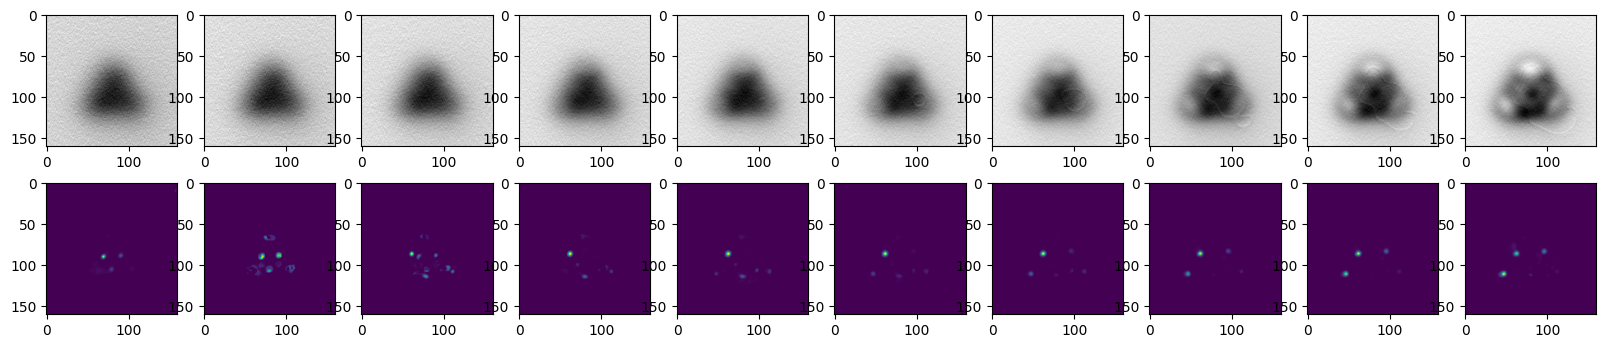

In [60]:
d = datasets['Br-Cl-I-Benzene'][0]
data = np.load(d, allow_pickle=True)

x, lx, ly = data["data"], data["lengthX"], data["lengthY"]
print(x.shape, lx, ly)
x = jnp.array(x)

x = x[..., -10:]
x = (x - x.mean()) / x.std()

# Current ångström / pixel ratio is lx / x.shape[0]
# Resize to 0.125 Å / pixel
new_size = (int(lx / 0.125), int(ly / 0.125))
x = transform.resize(x, new_size, mode='reflect', anti_aliasing=True)

# Crop x.shape[0] to the closest smaller multiple of 32
x = x[:x.shape[0] - x.shape[0] % 32, :x.shape[1] - x.shape[1] % 32]
print(x.shape)

x = x[None, ..., None]

y, _ = predict(state, x)
fig = plt.figure(figsize=(20, 8))
for i in range(10):
    ax = plt.subplot(1, 10, i+1)
    ax.imshow(x[0, ..., i, 0], cmap='gray')
    
    ax = plt.subplot(2, 10, i+11)
    ax.imshow(y[0, ..., i, 0], cmap='viridis', vmin=0)

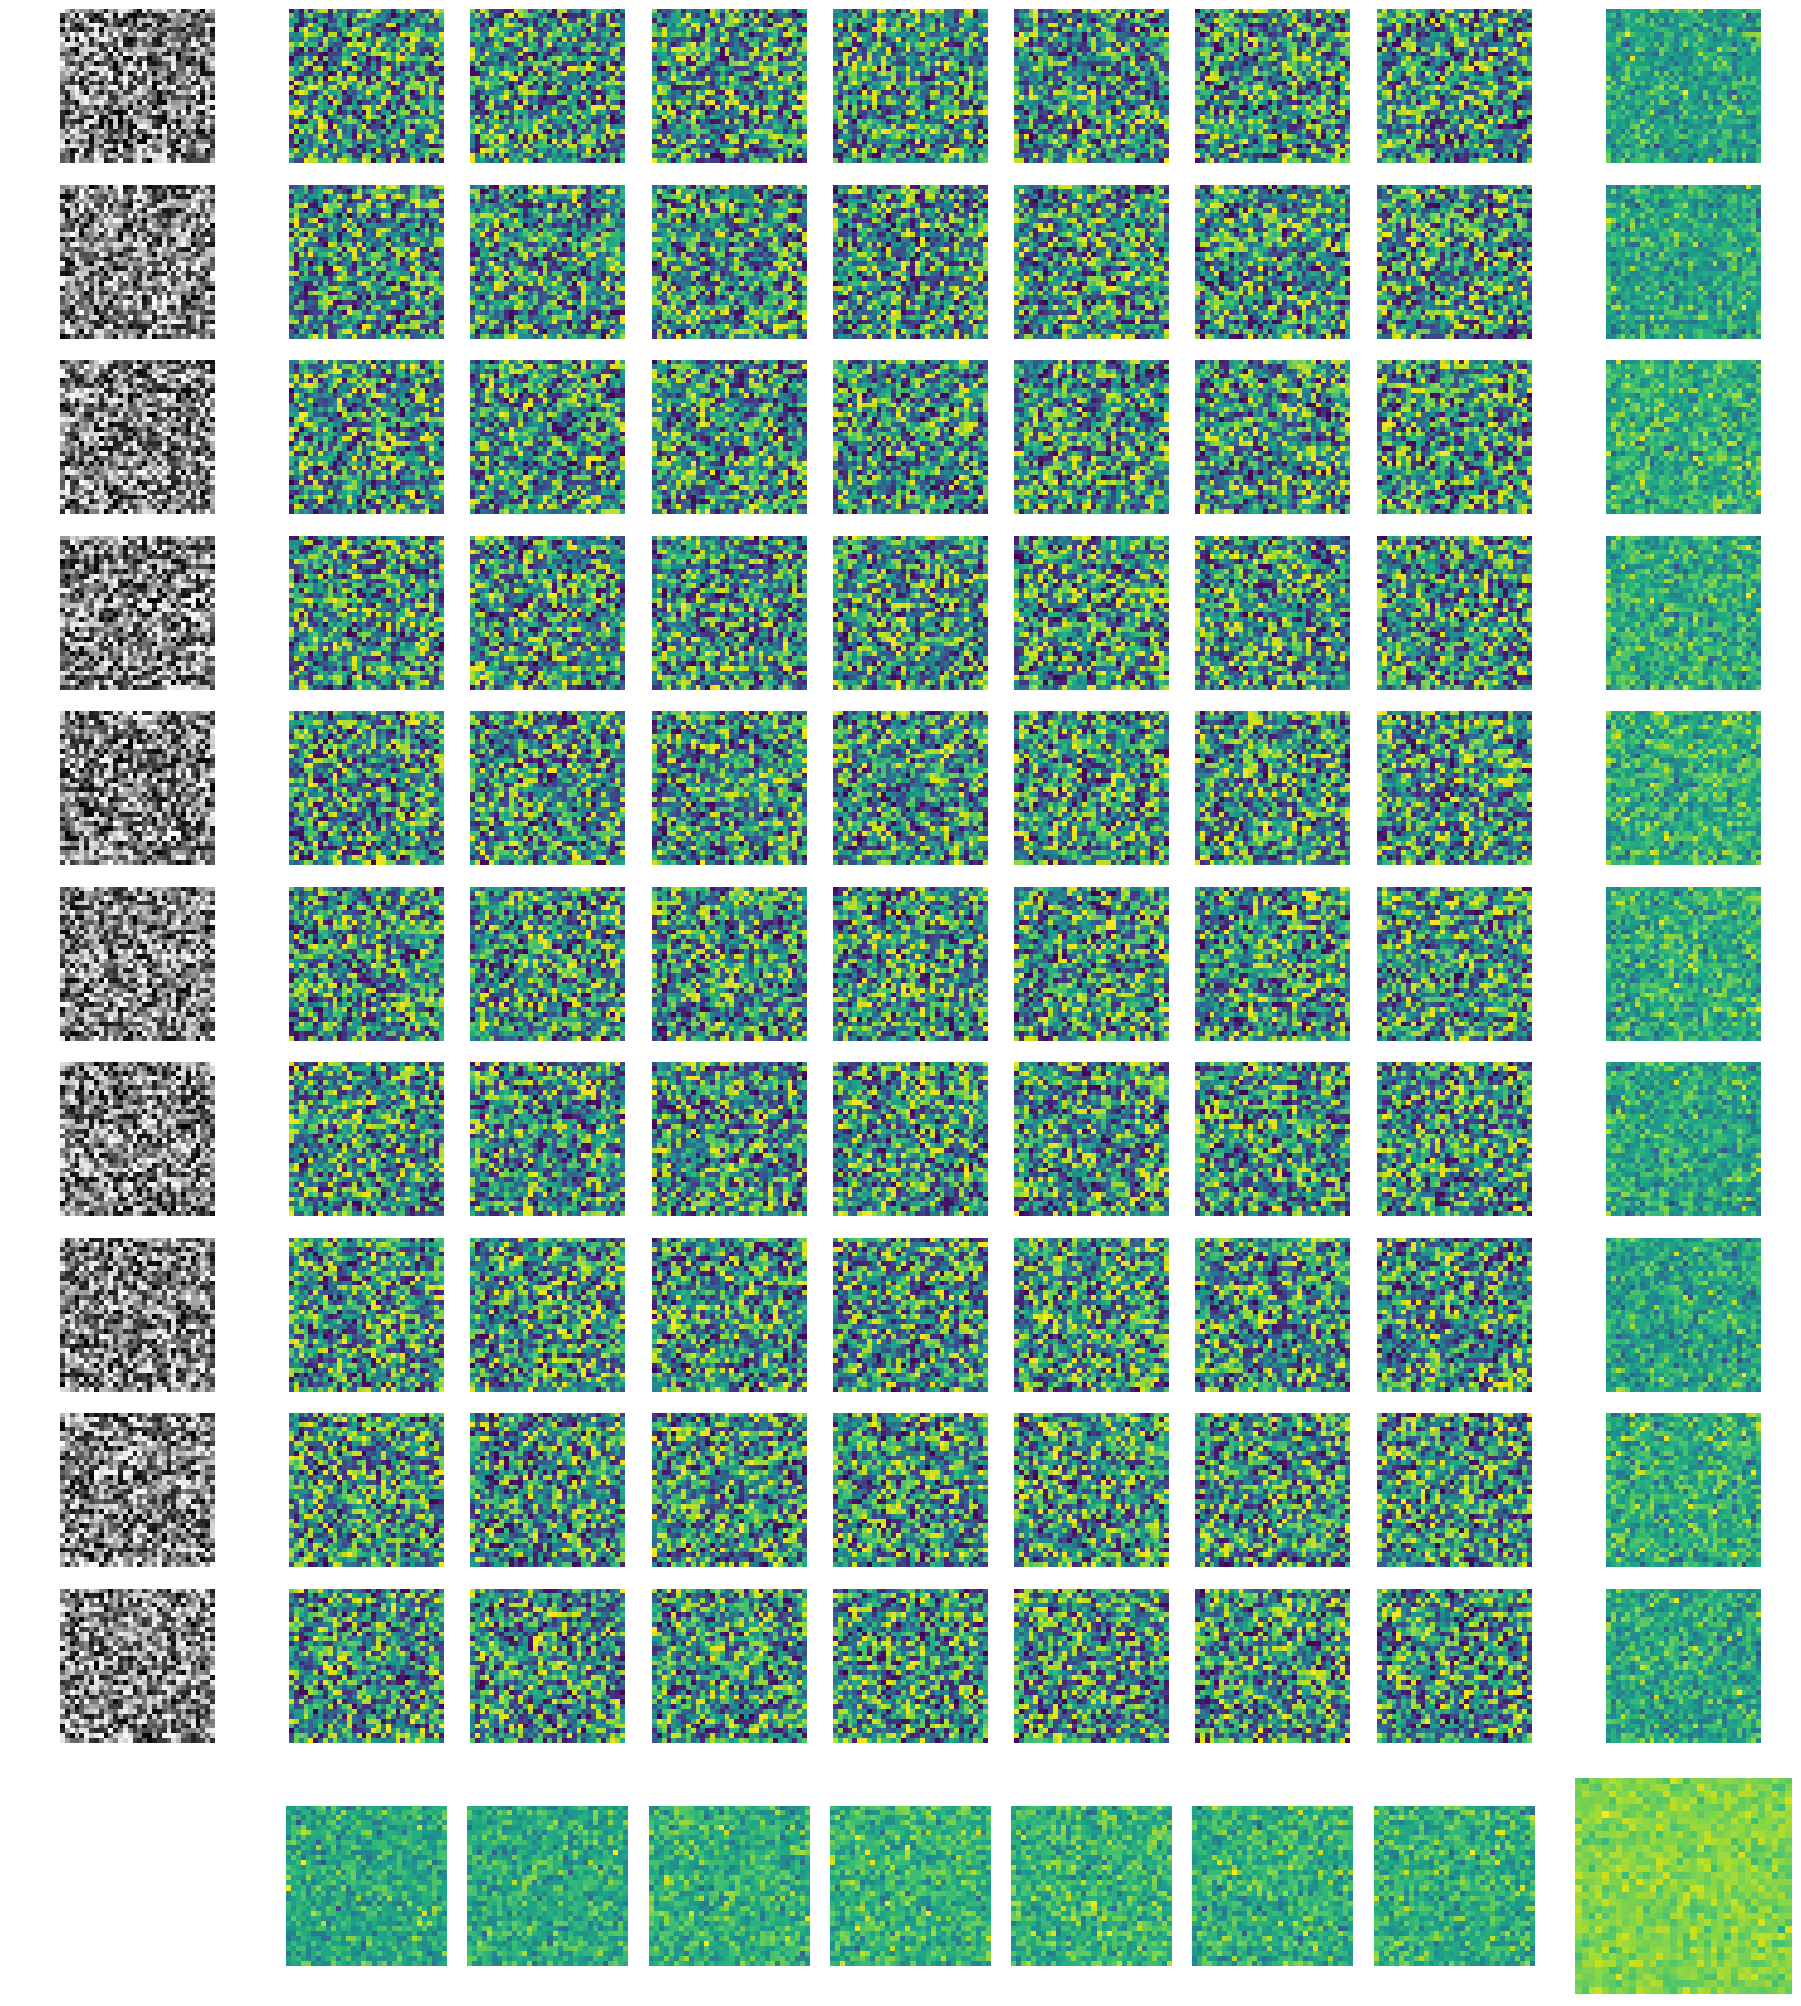

In [76]:
# 2. Plot the full prediction [1, x, y, z, element]
nrows = 10
ncols = 9
fig = plt.figure(figsize=(ncols * 2, nrows * 2))
subfigs = fig.subfigures(2, 3, height_ratios=[8, 1], width_ratios=[1, 5, 1], wspace=0.02, hspace=0.02)

x = np.random.rand(1, 32, 32, 10, 1)
y = np.random.rand(1, 32, 32, 10, 7)

# Plot the input in subfigs[0, 0]
ax = subfigs[0, 0].subplots(10,1)
for i in range(10):
    ax[i].imshow(x[0, ..., i, 0], cmap='gray')
    ax[i].axis('off')

# Plot the output in subfigs[0, 1]
ax = subfigs[0, 1].subplots(10, 7)
for i in range(10):
    for j in range(7):
        ax[i, j].imshow(y[0, ..., i, j], cmap='viridis', vmin=0)
        ax[i, j].axis('off')

# Plot the sum of the output in subfigs[0, 2]
ax = subfigs[0, 2].subplots(10, 1)
for i in range(10):
    ax[i].imshow(y[0, ..., i, :].sum(axis=-1), cmap='viridis', vmin=0)
    ax[i].axis('off')

# Plot the sum of the output in subfigs[1, 1]
ax = subfigs[1, 1].subplots(1, 7)
for i in range(7):
    ax[i].imshow(y[0, ..., :, i].sum(axis=-1), cmap='viridis', vmin=0)
    ax[i].axis('off')

# Plot the total sum in subfigs[1, 2]
ax = subfigs[1, 2].subplots(1, 1)
ax.imshow(y[0].sum(axis=(-1, -2)), cmap='viridis', vmin=0)
ax.axis('off')

plt.tight_layout()